In [21]:
import numpy as np


def sigmoid(Z):
    return 1. / (1. + np.exp(-Z))


def dsigmoid(Z):
    A = sigmoid(Z)
    return A * (1. - A)


def relu(Z):
    return np.maximum(0., Z)


def drelu(Z):
    return np.heaviside(Z, 0.)
    

def compute_cost(Yh, Y, parameters, lambd=0.):
    """
    Yh -- prediction vector of size(1, number of examples)
    Y -- label vector of size(1, number of examples)
    """
    m = Y.shape[1]
    L = len(parameters) // 2
    l2_regularization_cost = 0.
    for l in range(L):
        l2_regularization_cost = l2_regularization_cost + np.sum(np.square(parameters['W' + str(l+1)]))
    
    l2_regularization_cost = l2_regularization_cost * lambd / (2. * m)    
    cross_entropy_cost = (np.dot(Y, np.nan_to_num(np.log(Yh).T)) + np.dot((1. - Y), np.nan_to_num(np.log(1. - Yh).T)))/-m
        
    return cross_entropy_cost + l2_regularization_cost


def compute_dcost(Yh, Y):
    return -np.nan_to_num(np.divide(Y, Yh)) + np.nan_to_num(np.divide(1. - Y, 1. - Yh))
    

def initialize_parameters(layer_dims):
    parameters = {}
    
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters


def step_forward(W, b, Ap, activate):
    Z = np.dot(W, Ap) + b
    return Z, activate(Z)
    

def linear_forward_propagation(parameters, X, activation): 
    A = X
    m = X.shape[1]
    
    caches = []
    L = len(parameters) // 2 + 1
    
    for l in range(1, L):       
        Ap = A
        Z, A = step_forward(parameters['W' + str(l)], parameters['b' + str(l)], Ap, sigmoid if l == L - 1 else activation)
        caches.append((Z, Ap, parameters['W' + str(l)], parameters['b' + str(l)]))
    
    return A, caches


def step_backward(cache, dA, dactivation, lambd=0):
    Z, Ap, W, b = cache
    m = Z.shape[1]
    
    dZ = dA * dactivation(Z)
    dW = np.dot(dZ, Ap.T)/m + lambd/m * W
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dAp = np.dot(W.T, dZ) 
    
    return dAp, dW, db

    
def linear_backward_propagation(caches, Yh, Y, dactivation, lambd=0):    
    L = len(caches)
    grads = {}
    
    current_cache = caches[L-1]
    dAL = compute_dcost(Yh, Y)
    grads['dA' + str(L)] = dAL
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = step_backward(current_cache, dAL, dsigmoid, lambd)
    
    dA = grads['dA' + str(L-1)]
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads['dA' + str(l)], grads['dW' + str(l+1)], grads['db' + str(l+1)] = step_backward(current_cache, dA, dactivation, lambd) 
        dA = grads['dA' + str(l)]
        
    return grads


def predict(X, y, parameters, activation):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = linear_forward_propagation(parameters, X, activation)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p


def initialize_adam_variables(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)

    return v, s


def update_parameters(parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=10e-8):
    L = len(parameters) // 2
    
    v_crted = {}
    s_crted = {}
    for l in range(L):
        W_idx = "W" + str(l+1)
        b_idx = "b" + str(l+1)
        dW_idx = "d" + W_idx
        db_idx = "d" + b_idx
        
        # momentum
        v[dW_idx] = beta1 * v[dW_idx] + (1-beta1) * grads[dW_idx]    # exponentially weighted average
        v[db_idx] = beta1 * v[db_idx] + (1-beta1) * grads[db_idx]
        
        v_crted[dW_idx] = np.divide(v[dW_idx], 1 - beta1**t)         # to adjust early means 
        v_crted[db_idx] = np.divide(v[db_idx], 1 - beta1**t)
        
        # RMSprop
        s[dW_idx] = beta2 * s[dW_idx] + (1-beta2) * np.square(grads[dW_idx])
        s[db_idx] = beta2 * s[db_idx] + (1-beta2) * np.square(grads[db_idx])
        s_crted[dW_idx] = np.divide(s[dW_idx], 1 - beta2**t)
        s_crted[db_idx] = np.divide(s[db_idx], 1 - beta2**t)

        parameters[W_idx] = parameters[W_idx] - learning_rate * np.divide(v_crted[dW_idx], np.sqrt(s_crted[dW_idx]) + epsilon)
        parameters[b_idx] = parameters[b_idx] - learning_rate * np.divide(v_crted[db_idx], np.sqrt(s_crted[db_idx]) + epsilon)

    return parameters, v, s


def random_mini_batches(X, Y, mini_batch_size=0, seed=0):   
    m = X.shape[1]
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    if mini_batch_size == 0:
        mini_batch_size = m
        
    start = 0
    end = mini_batch_size
    batches = []
    while end < m:
        batches.append((shuffled_X[:, start:end], shuffled_Y[:, start:end]))
        start = end
        end += mini_batch_size
    
    if end >= m:
        batches.append((shuffled_X[:, start:m], shuffled_Y[:, start:m]))

    return batches


def nn_model(X, Y, layer_dims, mini_batch_size=0, learning_rate=0.3, epochs=30000, print_th_iter=10000, lambd=0., seed=0):
    """
    X -- data of size (n, number of examples)
    Y -- true "label" vector of size (1, number of examples)
    layer_dims -- the number of nodes in layers including X
    """
    parameters = initialize_parameters(layer_dims)
    v, s = initialize_adam_variables(parameters)
        
    for i in range(epochs):        
        seed = seed + 1               
        batches = random_mini_batches(X, Y, mini_batch_size, seed)
                       
        for mini_batch_X, mini_batch_Y in batches:            
            Yh, caches = linear_forward_propagation(parameters, mini_batch_X, relu)
            grads = linear_backward_propagation(caches, Yh, mini_batch_Y, drelu, lambd)
                
            cost = compute_cost(Yh, mini_batch_Y, parameters, lambd)
            parameters, v, s = update_parameters(parameters, grads, v, s, i+1, learning_rate)

        if (i % print_th_iter == 0):
            print("Cost after iteration {}: {}".format(i, cost))            

    return parameters, cost


def _to_theta_vector(dic, layers, wparam, bparam):
    L = layers    
    keys = []
    theta = None
    layer_dims = [dic[wparam + '1'].shape[1]]
    
    for l in range(1, L + 1):
        vw = dic[wparam + str(l)].reshape((-1, 1))
        vb = dic[bparam + str(l)].reshape((-1, 1))
        keys = keys + [wparam + str(l)]*vw.shape[0]
        keys = keys + [bparam + str(l)]*vb.shape[0]
        
        layer_dims = layer_dims + [dic[wparam + str(l)].shape[0]]
        if (l == 1):
            theta = np.append(vw, vb, axis=0)
        else:
            theta = np.append(theta, np.append(vw, vb, axis=0), axis=0)
        
    return theta, keys, layer_dims


def parameters_to_vector(parameters):
    return _to_theta_vector(parameters, len(parameters) // 2, 'W', 'b')


def gradients_to_vector(grads):
    return _to_theta_vector(grads, len(grads) // 3, 'dW', 'db')
    

def vector_to_parameters(theta, layer_dims):
    parameters = initialize_parameters(layer_dims)
    wstart = 0
    for l in range(1, len(layer_dims)):        
        wend = wstart + layer_dims[l] * layer_dims[l-1]
        bstart = wend
        bend = bstart + layer_dims[l] 
        parameters['W' + str(l)] = theta[wstart:wend, 0].reshape((layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = theta[bstart:bend, 0].reshape((layer_dims[l], 1))
        wstart = bend

    return parameters

        
def gradient_check(X, Y, activation, parameters, grads, epsilon=1e-7, lambd=0.):    
    theta, _, layer_dims = parameters_to_vector(parameters)    
    gradapprox = np.zeros((theta.shape[0], 1))
    # Loop for every single element in parameters (eg. W11, W12, W13, W21, ...)
    for idx in range(theta.shape[0]):
        theta_p = np.copy(theta)
        theta_p[idx, 0] = theta_p[idx, 0] + epsilon
        theta_m = np.copy(theta)
        theta_m[idx, 0] = theta_m[idx, 0] - epsilon
        
        params_p = vector_to_parameters(theta_p, layer_dims)
        Yh, caches = linear_forward_propagation(params_p, X, activation)
        J_p = compute_cost(Yh, Y, params_p, lambd)
        
        params_m = vector_to_parameters(theta_m, layer_dims)
        Yh, caches = linear_forward_propagation(params_m, X, activation)
        J_m = compute_cost(Yh, Y, params_m, lambd)

        gradapprox[idx] = (J_p - J_m) / (2. * epsilon)
    
    grads_v, _, _ = gradients_to_vector(grads)
    difference = np.linalg.norm(grads_v - gradapprox) / (np.linalg.norm(grads_v) + np.linalg.norm(gradapprox))
    if difference > 2e-7:
        print("There might be a mistake in backward propagation. difference: {}, grads_v: {}, gradapprox: {}".format(difference, grads_v, gradapprox))
    else:
        print("Backward propagation works correctly. difference: {}".format(difference))
    
    return difference


def accuracy(parameters, X, Y):
    p, caches = linear_forward_propagation(parameters, X, relu)
    return 100. - np.sum(np.abs(p - Y))/Y.shape[1] * 100


In [17]:
np.random.seed(1)
training_set_X = np.random.randn(3, 5)
training_set_Y = np.array([[1, 0, 0, 1, 1]])
test_set_X = np.random.randn(3, 5)
test_set_Y = np.array([[1, 0, 0, 1, 1]])

layer_dims = [3, 10, 1]

np.random.seed(1)
parameters = initialize_parameters(layer_dims)
Yh, caches = linear_forward_propagation(parameters, training_set_X, relu)
cost = compute_cost(Yh, training_set_Y, parameters)

print("Cost: {}".format(cost))

grads = linear_backward_propagation(caches, Yh, training_set_Y, drelu, lambd=0.)
gradient_check(training_set_X, training_set_Y, relu, parameters, grads, epsilon=1e-7, lambd=0)

np.random.seed(1)
parameters, cost = nn_model(training_set_X, training_set_Y, layer_dims, lambd=0., mini_batch_size=1, learning_rate=0.7, epochs=30000, print_th_iter=10000)
print("accurary for training: {}".format(accuracy(parameters, training_set_X, training_set_Y)))
print("accurary for test: {}".format(accuracy(parameters, test_set_X, test_set_Y)))


Cost: [[ 0.69228291]]
Backward propagation works correctly. difference: 1.7681006641674622e-09
m:5, per:[4, 2, 1, 3, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
Cost after iteration 0: [[ 0.]]
m:5, per:[2, 1, 4, 0, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 0, 2, 1, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 2, 1, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


m:5, per:[3, 1, 4, 2, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 4, 3, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 1, 0, 3, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 2, 0, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 1, 3, 2, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 2, 1, 4, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 0, 3, 1, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 1, 2, 0, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 4, 0, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 4, 3, 0, 2], X:[[ 1.62434536 -0.61175641 -0.5281717

m:5, per:[1, 3, 2, 4, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 4, 0, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 2, 3, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 0, 1, 2, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 2, 3, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 0, 4, 3, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 3, 4, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 0, 1, 4, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 1, 0, 4, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 1, 2, 4, 0], X:[[ 1.62434536 -0.61175641 -0.5281717

 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 1, 2, 4, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 1, 3, 2, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 4, 2, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 0, 4, 3, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 2, 1, 3], X:[[ 1.62434536 -0.61175641 -0.5281717

 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 2, 0, 4, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 2, 1, 4, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 2, 4, 1, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 1, 4, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 2, 1, 3], X:[[ 1.62434536 -0.61175641 -0.5281717

m:5, per:[1, 4, 2, 3, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 3, 0, 1, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 2, 3, 4, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 1, 4, 0, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 4, 3, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[2, 0, 1, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 2, 1, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 1, 0, 2, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 0, 1, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 1, 3, 4, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[2, 1, 4, 0, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 2, 4, 1, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 4, 0, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 2, 3, 1, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 0, 4, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[3, 0, 4, 2, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 2, 0, 4, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 4, 0, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 1, 2, 0, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 2, 0, 1, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[3, 4, 2, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 2, 1, 3, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 3, 0, 1, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 0, 4, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 4, 1, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[1, 3, 0, 4, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 1, 2, 3, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 1, 4, 3, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 1, 4, 2, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 4, 2, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[4, 2, 3, 1, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 1, 2, 0, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 1, 2, 0, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 4, 1, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 1, 2, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[3, 4, 1, 2, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 1, 4, 3, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 0, 2, 1, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 1, 2, 4, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 3, 2, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[3, 2, 4, 1, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 1, 4, 0, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 0, 1, 4, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 2, 0, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 0, 4, 3, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[3, 2, 0, 1, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 4, 1, 2, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 2, 1, 0, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 1, 4, 2, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 2, 4, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[2, 4, 3, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 1, 2, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 2, 3, 1, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 4, 1, 0, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 1, 3, 0, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 1, 2, 3, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[4, 2, 3, 1, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 4, 3, 1, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 2, 4, 0, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 2, 1, 4], X:[[ 1.62434536 -0.61175641 -0.5281717

 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 2, 3, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 4, 1, 2], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 3, 4, 2, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 4, 2, 0, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 0, 4, 2], X:[[ 1.62434536 -0.61175641 -0.5281717

m:5, per:[1, 0, 2, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 0, 2, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[2, 4, 3, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 0, 2, 4, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[3, 4, 2, 0, 1], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

m:5, per:[0, 2, 1, 3, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 1, 2, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 2, 3, 0, 4], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[0, 4, 1, 2, 3], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069   0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071 -0.3224172  -0.38405435  1.13376944]]
m:5, per:[1, 3, 4, 2, 0], X:[[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
 [-2.3015387   1.74481176 -0.7612069 

KeyboardInterrupt: 

Cost after iteration 0: [[ 0.75798832]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


Cost after iteration 10000: [[ 0.13805497]]
Cost after iteration 20000: [[ 0.1367235]]


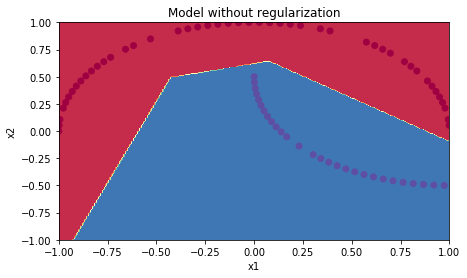

Accuracy: 1.0
Accuracy: 1.0
accurary for training: 97.48786545834484
accurary for test: 96.57362134060493


In [24]:
from reg_utils import load_2D_dataset, plot_decision_boundary 
import matplotlib.pyplot as plt
import scipy.io
import sklearn as sk

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = linear_forward_propagation(parameters, X, relu)
    predictions = (a3>0.5)
    return predictions


def make_moon(n_train=100, n_test=20):
    X, Y = sk.datasets.make_moons(n_samples = n_train + n_test)
    train_X = X[:n_train, :].T
    train_Y = Y[:n_train].reshape((1, n_train))
    test_X = X[n_train:n_train+n_test, :].T
    test_Y = Y[n_train:n_train+n_test].reshape((1, n_test))
    return train_X, train_Y, test_X, test_Y


np.random.seed(3)
train_X, train_Y, test_X, test_Y = make_moon(n_train=100, n_test=20)
layer_dims = [train_X.shape[0],  20, 3, 1]

parameters, cost = nn_model(train_X, train_Y, layer_dims, lambd=0.7, learning_rate=0.3, epochs=30000, print_th_iter=10000)

plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-1.,1.])
axes.set_ylim([-1.,1.])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

predict(train_X, train_Y, parameters, relu)
predict(test_X, test_Y, parameters, relu)
print("accurary for training: {}".format(accuracy(parameters, train_X, train_Y)))
print("accurary for test: {}".format(accuracy(parameters, test_X, test_Y)))


In [19]:
import sklearn as sk

X, Y = sk.datasets.make_moons(n_samples=20)
print(X)
print(Y.reshape((1, Y.shape[0])))

[[  1.50000000e+00  -3.66025404e-01]
 [  1.73648178e-01   9.84807753e-01]
 [  5.00000000e-01  -3.66025404e-01]
 [ -7.66044443e-01   6.42787610e-01]
 [ -5.00000000e-01   8.66025404e-01]
 [  1.00000000e+00   0.00000000e+00]
 [  1.93969262e+00   1.57979857e-01]
 [  1.76604444e+00  -1.42787610e-01]
 [  7.66044443e-01   6.42787610e-01]
 [ -1.00000000e+00   1.22464680e-16]
 [ -9.39692621e-01   3.42020143e-01]
 [  9.39692621e-01   3.42020143e-01]
 [  2.00000000e+00   5.00000000e-01]
 [ -1.73648178e-01   9.84807753e-01]
 [  5.00000000e-01   8.66025404e-01]
 [  6.03073792e-02   1.57979857e-01]
 [  0.00000000e+00   5.00000000e-01]
 [  8.26351822e-01  -4.84807753e-01]
 [  1.17364818e+00  -4.84807753e-01]
 [  2.33955557e-01  -1.42787610e-01]]
[[1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1]]
